# Regression topics

This section will go into more detail on running regressions in Python. We already saw an example using [factor models](10_factor_models.html#factor_models), like the CAPM and Fama-French 3-factor models. 

We could spend an entire semester going over linear regression, how to put together models, how to interpret models, and all of the adjustments that we can make. In fact, this is basically what a first-semester Econometrics class is!

I start by following code examples from [Coding for Economists](https://aeturrell.github.io/coding-for-economists/econmt-regression.html), which has just about everything you need to know to do basic linear regression (OLS) in Python. 

I then turn to **Chapters 3 and 10 from our Hull textbook**. These chapters focus on linear regression and how to interpret these types of model. They also discuss logit models, something that we get into in the next set of notes. In these notes, we'll see some newer regression topics from the machine learning perspective, such as **regularization, ridge regression, and lasso regression**. 

The Hull book also discusses **in-sample** vs. **out-of-sample** prediction. This topic comes up in Chapter 1 as well. 

[The Effect](https://theeffectbook.net) is a great book for getting starting with econometrics, regression, and how to add meaning to the regressions that we're running. [Chapter 13](https://theeffectbook.net/ch-StatisticalAdjustment.html) of that book covers regression (with code in R). Like most econometrics, that book is focused on **causality** - did some intervention or change **cause** a change in behavior or another outcome? These tools are beyond the scope of this course, but we have a new course on Causal Inference if you're interested.

You can read more about [the statsmodels library on their help page](https://www.statsmodels.org/dev/regression.html).

We are also going to use [linear regression from the sklearn libary](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). 

Two libraries, two ways to do regression. The Hull textbook uses `sklearn`.

You'll also see categorical variables and logs. Thinking about how to define our variables is an example of **feature engineering** in the machine learning world.



In [2]:
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score as r2
from sklearn.linear_model import LinearRegression

# Importing Ridge
from sklearn.linear_model import Ridge

# Import Lasso
from sklearn.linear_model import Lasso

# Import Elastic Net
from sklearn.linear_model import ElasticNet

#Need for AIC/BIC cross validation example
from sklearn.linear_model import LassoLarsIC
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold


# Include this to have plots show up in your Jupyter notebook.
%matplotlib inline 

pd.options.display.max_columns = None

## Example using Zillow pricing errors

I'll be using our Zillow pricing error data in this example. The `statsmodel` library will let us run the regressions and give us nicely formatted output.

In [4]:
housing = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/properties_2016_sample10_1.csv')
pricing = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/train_2016_v2.csv')

zillow_data = pd.merge(housing, pricing, how='inner', on='parcelid')
zillow_data['transactiondate'] = pd.to_datetime(zillow_data['transactiondate'], format='%Y-%m-%d')


/var/folders/kx/y8vj3n6n5kq_d74vj24jsnh40000gn/T/ipykernel_80516/4278326240.py:1: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  housing = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/properties_2016_sample10_1.csv')


In [30]:
zillow_data.describe()

,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,finishedfloor1squarefeet,calculatedfinishedsquarefeet,finishedsquarefeet12,finishedsquarefeet13,finishedsquarefeet15,finishedsquarefeet50,finishedsquarefeet6,fips,fireplacecnt,fullbathcnt,garagecarcnt,garagetotalsqft,heatingorsystemtypeid,latitude,longitude,lotsizesquarefeet,poolcnt,poolsizesum,pooltypeid7,propertylandusetypeid,rawcensustractandblock,regionidcity,regionidcounty,regionidneighborhood,regionidzip,roomcnt,storytypeid,threequarterbathnbr,typeconstructiontypeid,unitcnt,yardbuildingsqft17,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,logerror
count,9.071000e+03,2871.000000,0.0,5.00000,9071.000000,9071.000000,3.0,5694.000000,8948.000000,64.0,695.000000,9001.000000,8612.000000,3.000000,337.000000,695.000000,49.000000,9071.000000,993.000000,8948.000000,3076.000000,3076.000000,5574.000000,9.071000e+03,9.071000e+03,8.020000e+03,1810.0,99.000000,1685.0,9071.000000,9.071000e+03,8912.000000,9071.000000,3601.000000,9070.000000,9071.000000,5.0,1208.000000,0.0,5794.000000,280.000000,7.000000,8991.000000,2138.000000,9.022000e+03,9.071000e+03,9071.0,9.071000e+03,9071.000000,168.000000,9.009000e+03,9071.000000
mean,1.298764e+07,1.838036,NaN,516.00000,2.266233,3.013670,4.0,5.572708,2.296826,66.0,1348.981295,1767.239307,1740.108918,1408.000000,2393.350148,1368.942446,2251.428571,6049.128982,1.197382,2.228990,1.800715,342.415475,3.909760,3.400230e+07,-1.181977e+08,3.150909e+04,1.0,520.424242,1.0,261.835520,6.049436e+07,33944.006845,2511.879727,193520.398223,96547.689195,1.531364,7.0,1.004967,NaN,1.104764,290.335714,496.714286,1968.380047,1.428438,1.768673e+05,4.523049e+05,2015.0,2.763930e+05,5906.696988,13.327381,6.049368e+13,0.010703
std,1.757451e+06,3.001723,NaN,233.49197,0.989863,1.118468,0.0,1.908379,0.960557,0.0,664.508053,918.999586,880.213401,55.425626,1434.457485,709.622839,1352.034747,20.794593,0.480794,0.951007,0.598328,263.642761,3.678727,2.654493e+05,3.631575e+05,1.824345e+05,0.0,146.537109,0.0,5.781663,2.063550e+05,47178.373342,810.417898,169701.596819,412.732130,2.856603,0.0,0.070330,NaN,0.459551,172.987812,506.445033,23.469997,0.536698,1.909207e+05,5.229433e+05,0.0,3.901131e+05,6388.966672,1.796527,2.053649e+11,0.158364
min,1.071186e+07,1.000000,NaN,162.00000,0.000000,0.000000,4.0,1.000000,1.000000,66.0,49.000000,214.000000,214.000000,1344.000000,716.000000,49.000000,438.000000,6037.000000,1.000000,1.000000,0.000000,0.000000,1.000000,3.334420e+07,-1.194143e+08,4.350000e+02,1.0,207.000000,1.0,31.000000,6.037101e+07,3491.000000,1286.000000,6952.000000,95982.000000,0.000000,7.0,1.000000,NaN,1.000000,41.000000,37.000000,1885.000000,1.000000,1.516000e+03,7.837000e+03,2015.0,2.178000e+03,96.740000,7.000000,6.037101e+13,-2.365000
25%,1.157119e+07,1.000000,NaN,485.00000,2.000000,2.000000,4.0,4.000000,2.000000,66.0,938.000000,1187.000000,1173.000000,1392.000000,1668.000000,938.000000,1009.000000,6037.000000,1.000000,2.000000,2.000000,0.000000,2.000000,3.380545e+07,-1.184080e+08,5.746500e+03,1.0,435.000000,1.0,261.000000,6.037400e+07,12447.000000,1286.000000,46736.000000,96193.000000,0.000000,7.0,1.000000,NaN,1.000000,175.750000,110.500000,1953.000000,1.000000,8.028525e+04,1.926595e+05,2015.0,8.060700e+04,2828.645000,13.000000,6.037400e+13,-0.025300
50%,1.259048e+07,1.000000,NaN,515.00000,2.000000,3.000000,4.0,7.000000,2.000000,66.0,1249.000000,1539.000000,1513.000000,1440.000000,2157.000000,1257.000000,1835.000000,6037.000000,1.000000,2.000000,2.000000,430.000000,2.000000,3.401408e+07,-1.181670e+08,7.200000e+03,1.0,504.000000,1.0,261.000000,6.037621e+07,25218.000000,3101.000000,118887.000000,96401.000000,0.000000,7.0,1.000000,NaN,1.000000,248.500000,268.000000,1969.000000,1.000000,1.315530e+05,3.416920e+05,2015.0,1.910000e+05,4521.580000,1

I'll print a list of the columns, just to see what our variables are. There's a lot in this data set.

In [31]:
zillow_data.columns

Index(['parcelid', 'airconditioningtypeid', 'architecturalstyletypeid',
       'basementsqft', 'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertylandusetypeid',
       'propertyzoningdesc', 'rawcensustractandblock', 'regionidcity',
       'regionidcounty', 'regionidneighborhood', 'regionidzip', 'roomcnt',
       'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid',
       'unitcnt', 'yardbuildingsqft17', 'yardbuildin

Let's run a really simple regression. Can we explain pricing errors using the size of the house? I'll take the natural log of `calculatedfinishedsquarefeet` and use that as my independent (**X**) variable. My dependent (**Y**) variable will be `logerror`. I'm taking the natural log of the square footage, in order to have what's called a "log-log" model.

In [32]:
zillow_data['ln_calculatedfinishedsquarefeet'] = np.log(zillow_data['calculatedfinishedsquarefeet'])

results = smf.ols("logerror ~ ln_calculatedfinishedsquarefeet", data=zillow_data).fit()


In [33]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     13.30
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           0.000267
Time:                        12:21:17   Log-Likelihood:                 3831.8
No. Observations:                9001   AIC:                            -7660.
Df Residuals:                    8999   BIC:                            -7645.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

That's the full summary of the regression. This is a "log-log" model, so we can say that a 1% change in square footage leads to a 1.39% increase in pricing error. The coefficient is positive and statistically significant at conventional levels (e.g. 1%). 

We can pull out just a piece of this full result if we like. 

In [34]:
results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,-0.0911,0.028,-3.244,0.001,-0.146,-0.036
ln_calculatedfinishedsquarefeet,0.0139,0.004,3.647,0.000,0.006,0.021


We can, of course, include multiple **X** variables in a regression. I'll add bathroom and bedroom counts to the regression model.

In [35]:
results = smf.ols("logerror ~ ln_calculatedfinishedsquarefeet + bathroomcnt + bedroomcnt", data=zillow_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     6.718
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           0.000159
Time:                        12:21:17   Log-Likelihood:                 3835.2
No. Observations:                9001   AIC:                            -7662.
Df Residuals:                    8997   BIC:                            -7634.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Hey, all of my significance went away! Welcome to the world of [multicollinearity](https://en.wikipedia.org/wiki/Multicollinearity). All of these variables are very correlated, so the coefficient estimates become difficult to interpret.

Watch what happens when I just run the model with the bedroom count. The $t$-statistic is quite large again.

In [36]:
results = smf.ols("logerror ~ bedroomcnt", data=zillow_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     21.69
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           3.24e-06
Time:                        12:21:18   Log-Likelihood:                 3856.7
No. Observations:                9071   AIC:                            -7709.
Df Residuals:                    9069   BIC:                            -7695.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0101      0.005     -2.125      0.0

## Indicators and categorical variables

The variables used above are measured numerically. Some are **continuous**, like square footage, while others are **counts**, like the number of bedrooms. Sometimes, though, we want to include an **indicator** for something? For example, does this house have a pool or not?

There is a variable in the data called `poolcnt`. It seems to be either missing (NaN) or set equal to 1. I believe that a value of 1 means that the house has a pool and that `NaN` means that it does not. This is bit of a tricky assumption, because `NaN` could mean no pool or that we don't know either way. But, I'll make that assumption for illustrative purposes.

In [37]:
zillow_data['poolcnt'].describe()

count    1810.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: poolcnt, dtype: float64

I am going to create a new variable, `pool_d`, that is set equal to 1 if `poolcnt >= 1` and 0 otherwise. This type of 1/0 categorical variable is sometimes called an **indicator**, or **dummy** variable. 

In [38]:
zillow_data['pool_d'] = np.where(zillow_data.poolcnt.isnull(), 0, zillow_data.poolcnt >= 1)
zillow_data['pool_d'].describe()

count    9071.000000
mean        0.199537
std         0.399674
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: pool_d, dtype: float64

I can then use this 1/0 variable in my regression.

In [39]:
results = smf.ols("logerror ~ ln_calculatedfinishedsquarefeet + pool_d", data=zillow_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     6.684
Date:                Thu, 21 Apr 2022   Prob (F-statistic):            0.00126
Time:                        12:21:18   Log-Likelihood:                 3831.8
No. Observations:                9001   AIC:                            -7658.
Df Residuals:                    8998   BIC:                            -7636.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

Pools don't seem to influence pricing errors. 

We can also create more general **categorical** variables. For example, instead of treating bedrooms like a count, we can create new categories for each number of bedrooms. This type of model is helpful when dealing states or regions. For example, you could turn a zip code into a categorical variable. This would allow zip codes, or a location, to explain the pricing errors. 

In Python, you can turn something into a categorical variable by using `C()` in the regression formula. 

I'll try the count of bedrooms first.

In [40]:
results = smf.ols("logerror ~ ln_calculatedfinishedsquarefeet + C(bedroomcnt)", data=zillow_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     3.118
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           0.000196
Time:                        12:21:18   Log-Likelihood:                 3843.8
No. Observations:                9001   AIC:                            -7662.
Df Residuals:                    8988   BIC:                            -7569.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

And here are zip codes as a categorical variable. This is saying: Is the house in this zip code or no? If it is, the indicator for that zip code gets a 1, and a 0 otherwise. If we didn't do this, then the zip code would get treated like a numerical variable in the regression, like square footage, which makes no sense!

In [42]:
results = smf.ols("logerror ~ ln_calculatedfinishedsquarefeet + C(regionidzip)", data=zillow_data).fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:               logerror   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     1.300
Date:                Thu, 21 Apr 2022   Prob (F-statistic):           0.000104
Time:                        12:21:32   Log-Likelihood:                 4075.3
No. Observations:                9001   AIC:                            -7391.
Df Residuals:                    8621   BIC:                            -4691.
Df Model:                         379                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

## Hull, Chapters 3 and 10. Linear regression.

Chapter 3.1 starts off with the match behind linear regression with one feature. This is just what we did above, when we tried to explain pricing errors with one variable. This math and how regression works should be familiar from your introductory statistics course. Notice the idea of a **training set**. This is the data that we use to create our model. We are then going to take the outputs (i.e. the coefficients) from this model and use it to predict values in the **out-of-sample** data.

To be more precise, the textbook introduces the idea of **three different types of data sets: training, validation, and testing**. Let's ask Claude GPT the differences:

> In machine learning, data is typically split into three subsets: training data, validation data, and test data. Each subset serves a different purpose in the model development and evaluation process.

> Training Data: The training data is the largest portion of the dataset, and it is used to train the machine learning model. During the training process, the model learns patterns and relationships from the training data. The model's parameters are adjusted to minimize the error or loss function on this data.

> Validation Data: The validation data is a subset of the data held out from the training process. It is used to evaluate the performance of the model during the training phase. The validation data provides an unbiased estimate of the model's performance on unseen data. It helps tune the **hyperparameters** of the model, such as the learning rate, regularization strength, or the number of iterations. The validation data is used to prevent **overfitting**, which occurs when the model performs well on the training data but fails to generalize to new, unseen data. By monitoring the performance on the validation data, early stopping or regularization techniques can be applied to improve the model's generalization capability.

> Test Data: The test data is a separate subset of the data that is completely isolated from the training and validation processes. It is used to evaluate the final performance of the trained model on unseen data, providing an unbiased estimate of the model's real-world performance. The test data should be representative of the data the model will encounter in production or real-world scenarios. The performance metrics calculated on the test data, such as accuracy, precision, recall, or F1-score, are considered the final, reliable indicators of the model's effectiveness.

> It is crucial to keep the test data separate and untouched during the training and validation phases to avoid any data leakage or overfitting to the test data. The test data should only be used once, after the model has been fully trained and tuned, to obtain an unbiased estimate of its performance.

> By splitting the data into these three subsets, machine learning practitioners can train models effectively, tune hyperparameters, and evaluate the final performance objectively, ensuring that the model will generalize well to new, unseen data.


You are going to see these ideas as we go. `sklearn` has many built-in features to help, like ways to automatically split your data, though the textbook tends to do things manually. 


Chapter 3.2 introduces **multiple features**. Again, this just means multiple explanatory X variables. Eq. 3.1 gives us the general form of a linear regression model:

\begin{align}
Y = a + b_1 X_1 + b_2 X_2 + \cdots + b_m X_m + \varepsilon
\end{align}

The [statsmodel](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html) page for linear regression has helpful code examples, including how to generate dummy variables (see below).


### Important regression statistics

What is regression trying to do? Hull discusses these linear models from the machine learning perspective. So, rather than a discussion of the [Gauss-Markov theorem and BLUE](https://en.wikipedia.org/wiki/Gauss–Markov_theorem), we get something less theoretical. 

In short, the linear regression algorithm selects values for $a$ and each $b$ above that minimize the sum of the squared differences between each Y and its predicted value (i.e. the right-hand side of the equation). This is shown in Eq. 3.2. Why do we square the differences? The direction of the error doesn't matter - we want predicted values to be close to the actual value. 

The text notes that $a$ is called the model **bias** and the $b$ values are called the model **weights**. In econometrics, we call $a$ the **intercept** and the $b$ values **coefficients**. 

Machine learning techniques are all about **prediction**. How well does the model predict or fit the data? To measure this, we can use the **R-Squared** value for the model. 

\begin{align}
R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}
\end{align}

We can also put this into words:

\begin{align}
R^2 = 1 - \frac{\text{Variance of the errors } \epsilon}{\text{Variation of the observations on the target Y}}
\end{align}

As noted by the text:

> The R-squared statistic is between zero and one and measures the proportion of the variance in the target that is explained by the features.

This is a statistics for the entire model. We also care about how well each feature (variable) does in explaining the variation in our outcome/target/Y variable. We use *t*-statistics for that. 

Again, from the text:

> The *t*-statistic of the $a$ or $𝑏_𝑗$ parameters estimated by a linear regression is the value of the parameter divided by its standard error. The P-value is the probability of obtaining a *t*-statistic as large as the one observed if we were in the situation where the parameter had no explanatory power at all. A P-value of 5% or less is generally considered as indicating that the parameter is significant. If the P-value for the parameter $b_j$ in equation (3.1) is less than 5%, we are over 95% confident that the feature $X_j$ has some effect on Y. The critical t-statistic for 95% confidence when the data set is large is 1.96 (i.e., t-statistics greater than  1.96 are significant in the sense that they give rise to P-values less than 5%).

I would take issue with some of the language in that explanation. These values are about relationships and correlations, but I see *effect* in that description. Saying that these correlations are actually causal relationships requires assumptions that go beyond pure statistics. You need a model. In our case, this would mean an economic model that describes incentives and behavior. 


### Categorical features

We saw these above, when we used *bedroomcnt*. From the Hull text:

> A common practice is to use  the same number of dummy variables as there are categories and associate each dummy variable with a particular category. The value of a  dummy variable is one if the corresponding category applies and zero  otherwise. This is referred to as one-hot encoding.

The text also discusses the **dummy variable trap**. If you create a dummy variable for each categorical value and then add a constant to the regression model, then you're model is **overfit** and will not estimate. In economics, we usually include a constant or intercept term in our regressions. This isn't always the case in machine learning. 


### Regularization and Ridge regression

These next three methods come from the machine learning literature and help to deal with having **too many explanatory variables**. When I say this, I mean that they come more from the computer science and statistics world than the econometrics world. This distinction is meaningful if you're trained in one set of methods vs. another, but is becoming less important over time as machine learning and econometrics borrow from each other. 

```{margin} What is econometrics?
Econometrics is usually interested in causal relationships among economic agents. So, does more schooling increase wages, or do the people who are good at school also earn more? These are difficult questions to answer and economists have developed a variety of tools to help. If you've taken econometrics, then you've seen topics like instrumental variables and difference-in-differences. In economics, we're more interested in explaining why something is happening than predicting an outcome. So, did a change in a zoning law affect housing prices, rather than predicting a pricing error. 
```

Why are too many explanatory (X) variables a problem? They make the math harder when different X variables are correlated with one another. In other words, we have different features in our data that are really explaining the same thing. The book uses the area of the basement and the area of the first floor of a house as an example. These values are different, but capture the same thing, generally speaking - house size. 

**Regularization** helps use reduce the number of variables used in our model. We are also going to see more **scaling** of features. It is important to scale (e.g. Z-score) in order for different features to be comparable with each other.

Here's a [sklearn article](https://scikit-learn.org/stable/auto_examples/preprocessing/plot_scaling_importance.html) on the importance of scaling your features before using them in a machine learning model. From the article:

> Feature scaling through standardization, also called Z-score normalization, is an important preprocessing step for many machine learning algorithms. It involves rescaling each feature such that it has a standard deviation of 1 and a mean of 0.

One way to regularize our model is to use a **Ridge regression**. This algorithm chooses $a$ and $b$ parameters to minimize this function:


\begin{align}
\frac{1}{n}\sum_{i=1}^{n}(Y_i - a - b_1X_{i1} - b_2X_{i2} - \cdots - b_mX_{im})^2 + \lambda\sum_{j=1}^{m}b_j^2
\end{align}

Note that this looks a lot like a normal regression, except that we now have the last term with $\lambda$ and $b^2$. From the text:

> This change has the effect of encouraging the model to keep the weights $b_j$ as small as possible.

This method is also called **L2 regularization**. Why do we do this? From the text:

> L2 regularization is one way of avoiding the situation such as that in equation (3.3) where there are two correlated features, one with a large positive weight and the other with a large negative weight. Its general effect is to **simplify a linear regression model**. Sometimes, the model obtained after regularization generalizes better than the model before regularization. 

How do we choose a value for $\lambda$? From the text:

> The parameter $\lambda$ is referred to as a **hyperparameter** because it is used as a tool to determine the best model but is not part of the model itself. The choice of a value for $\lambda$ is obviously important. A large value for λ would lead to all the $b_j$ being set equal to zero. (The resulting model would then be uninteresting as it would always predict a value equal to $a$ for Y.) In practice, it is desirable to try several different values for $\lambda$ and choose between the resulting models.

If $\lambda$ is set to zero, then we have linear regression. As you increase $\lambda$, the model will become **less complex**.

Take a look at **footnote 3**. `sklearn` uses the **sum of squared errors** rather than the **mean sum of squared errors**. In other words, there's no $\frac{1}{n}$ out in front of the Ridge regression formula. So, you have to multiple your lambda term by $n$, or the number of observations, when using it. See more below, where I work the example in the Hull text.



### Lasso regression

From the Hull text:

> In Ridge, we added a constant times the sum of the squared weights to the objective function. In Lasso, we add a constant times the sum of the **absolute weights**.

Lasso is also called **L1 regularization**. This changes the last term in the equation that we are trying to minimize:

\begin{align}
\frac{1}{n}\sum_{i=1}^{n}(Y_i - a - b_1X_{i1} - b_2X_{i2} - \cdots - b_mX_{im})^2 + \lambda\sum_{j=1}^{m}|b_j|
\end{align}

I asked the Claude GPT to explain this equation:

> This equation represents the objective function for Lasso (Least Absolute Shrinkage and Selection Operator) regression. Lasso is a type of linear regression that uses L1 regularization to add a penalty term to the cost function. This penalty term encourages sparse solutions, driving some coefficient estimates to exactly zero, effectively performing variable selection and improving interpretability of the model. The first term is the regular least squares error term that measures the model's fit to the data. The second term is the L1 regularization penalty on the sum of the absolute values of the coefficients ($|b_j|$), multiplied by a tuning parameter lambda that controls the strength of the penalty.

> By minimizing this objective function, Lasso regression aims to find the best fit linear model while also promoting sparsity in the coefficients, making it useful for scenarios with many potential predictor variables.

Using Lasso is going to mean having more $b = 0$ values. In other words, some features are "kicked out of the model" in order to simplify things. This is going to happen when **certain features explain the same variation in the Y variable**. 

Again, check out footnote 4 for some details on how lasso works in `sklearn`. 



### Elastic net regression

Elastic Net regression is a **mixture of Ridge and Lasso**. The function to be minimized includes both a constant times the sum of the squared weights and a different constant times the sum of the absolute values of the weights.

\begin{align}
\frac{1}{n}\sum_{i=1}^{n}(Y_i - a - b_1X_{i1} - b_2X_{i2} - \cdots - b_mX_{im})^2 + \lambda_1\sum_{j=1}^{m}b_j^2 + \lambda_2\sum_{j=1}^{m}|b_j|
\end{align}

From the text:

>In Lasso some weights are set to zero, but others may be quite large in magnitude. In Ridge, weights are small in magnitude, but they are not reduced to zero. The idea underlying Elastic Net is that we may be able to get the **best of both worlds** by making some weights zero while reducing the magnitude of the others.

From Claude GPT:

> This equation represents the objective function for Elastic Net regularization, which is a linear regression model that combines the L1 (Lasso) and L2 (Ridge) regularization techniques. The first term is the standard mean squared error term, which measures the difference between the predicted values and the actual target values ($Y_i$) for the given data points ($X_{i1}$, $X_{i2}$, ..., $X_{im}$). 

> The second term is the L2 regularization penalty, also known as the Ridge penalty, which adds the sum of the squared coefficients ($b_j^2$) multiplied by a tuning parameter $λ_1$. This penalty encourages small coefficient values and helps to prevent overfitting.

> The third term is the L1 regularization penalty, also known as the Lasso penalty, which adds the sum of the absolute values of the coefficients ($|b_j|$) multiplied by a tuning parameter $λ_2$. This penalty promotes sparsity in the model by driving some coefficients to exactly zero, effectively performing variable selection.

>By combining the L1 and L2 penalties, Elastic Net regularization aims to benefit from the strengths of both Ridge and Lasso regularization. It can handle correlated predictors better than Lasso and can select more predictive features than Ridge regression. The tuning parameters $λ_1$ and $λ_2$ control the relative importance of the L1 and L2 penalties, respectively. Elastic Net regularization is particularly useful when dealing with high-dimensional data with potentially correlated predictors, where both variable selection and coefficient shrinkage are desirable.



### Using our tools to predict housing prices

I'm going to replicate the Hull textbook results below. This data has housing sale prices and features about each house. The houses are in Iowa and represent sales over a four year period. The data has already been scaled so that each feature has a mean of 0 and a standard deviation of 1.

The text describes the data and its structure. We are going to create training, validation, and testing data sets. Note that the data are already cleaned up for you. If you were doing this on your own, you'd need to do the steps described on pg. 65.

Notice how this is a different question from the Zillow data. We're directly predicting housing prices here, not Zillow's pricing errors. Zillow was trying to identify the types of houses that were difficult to price using their Zestimate model.

In [5]:
# Both features and target have already been scaled: mean = 0; SD = 1
data = pd.read_csv('https://raw.githubusercontent.com/aaiken1/fin-data-analysis-python/main/data/Houseprice_data_scaled.csv') 

We are going to split this data into **training** and **validation** sets. We'll estimate the model on the training data and then check it using the validation set. Note the use of `.iloc`. You could also randomly sample the data.

In [93]:
# First 1800 data items are training set; the next 600 are the validation set
train = data.iloc[:1800] 
val = data.iloc[1800:2400]

We then separate the X and Y variables into do different data sets. This is just the way the `sklearn` package wants things.

In [101]:
# Creating the "X" and "y" variables. We drop sale price from "X"
X_train, X_val = train.drop('Sale Price', axis=1), val.drop('Sale Price', axis=1)
y_train, y_val = train[['Sale Price']], val[['Sale Price']] 

In [102]:
y_train.head()

,Sale Price
0,0.358489
1,0.008849
2,0.552733
3,-0.528560
4,0.895898


In [111]:
X_train.head()

,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,Blmngtn,Blueste,BrDale,BrkSide,ClearCr,CollgCr,Crawfor,Edwards,Gilbert,IDOTRR,MeadowV,Mitchel,Names,NoRidge,NPkVill,NriddgHt,NWAmes,OLDTown,SWISU,Sawyer,SawyerW,Somerst,StoneBr,Timber,Veenker,Bsmt Qual
0,-0.199572,0.652747,-0.512407,1.038851,0.875754,0.597837,-0.937245,-0.482464,-0.808820,1.203988,0.423045,0.789653,1.208820,0.173443,0.960943,-0.947675,0.304041,0.348200,-0.749963,0.222420,-0.357173,-0.103258,-0.04718,-0.10597,-0.19657,-0.134497,3.222830,-0.177486,-0.255054,-0.253817,-0.150714,-0.108618,-0.188821,-0.446195,-0.163696,-0.097618,-0.251329,-0.23069,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308
1,-0.072005,-0.072527,2.189741,0.136810,-0.432225,1.218528,-0.635042,0.490326,0.276358,-0.789421,-0.490655,0.789653,-0.769249,0.173443,-0.297934,0.608725,0.304041,-0.070795,1.637145,-0.718903,-0.357173,-0.103258,-0.04718,-0.10597,-0.19657,-0.134497,-0.310114,-0.177486,-0.255054,-0.253817,-0.150714,-0.108618,-0.188821,-0.446195,-0.163696,-0.097618,-0.251329,-0.23069,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,10.905682,0.584308
2,0.111026,0.652747,-0.512407,0.972033,0.827310,0.095808,-0.296754,-0.329118,-0.637758,1.231999,0.578048,0.789653,1.208820,0.173443,-0.297934,0.608725,0.304041,0.633878,-0.749963,-0.070779,-0.357173,-0.103258,-0.04718,-0.10597,-0.19657,-0.134497,3.222830,-0.177486,-0.255054,-0.253817,-0.150714,-0.108618,-0.188821,-0.446195,-0.163696,-0.097618,-0.251329,-0.23069,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308
3,-0.077551,0.652747,-0.512407,-1.901135,-0.722887,-0.520319,-0.057698,-0.722067,-0.528171,0.975236,0.437322,-1.039659,-0.769249,0.173443,0.331504,0.608725,1.648693,0.795763,-0.749963,-0.178800,4.059560,-0.103258,-0.04718,-0.10597,-0.19657,-0.134497,-0.310114,5.631132,-0.255054,-0.253817,-0.150714,-0.108618,-0.188821,-0.446195,-0.163696,-0.097618,-0.251329,-0.23069,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,-0.577852
4,0.444919,1.378022,-0.512407,0.938624,0.730423,0.481458,-0.170461,0.209990,-0.036366,1.668495,1.418326,0.789653,1.208820,1.407428,1.590381,0.608725,1.648693,1.719456,0.788039,0.577345,-0.357173,-0.103258,-0.04718,-0.10597,-0.19657,-0.134497,-0.310114,-0.177486,-0.255054,-0.253817,-0.150714,-0.108618,-0.188821,-0.446195,6.105502,-0.097618,-0.251329,-0.23069,-0.286942,-0.136621,-0.2253,-0.214192,-0.268378,-0.127929,-0.152629,-0.091644,0.584308


Now we can create the model. We are creating a linear regression object from the sklearn library. We then fit the model using our X and y training data. The results live inside of this object.

In [103]:
lr = LinearRegression()

lr.fit(X_train, y_train)

LinearRegression()

In [104]:
type(lr)

sklearn.linear_model._base.LinearRegression

We can pull values out of this model, but they aren't easy to read. 

In [105]:
lr.intercept_

array([-21.19019074])

In [106]:
lr.coef_

array([[ 7.89996182e-02,  2.14717552e-01,  9.56481737e-02,
         1.59774166e-01,  2.53592150e-02,  9.21317505e-02,
        -3.24714879e-02,  1.37952329e-01,  1.60622470e-01,
         1.42606877e-01,  1.50644782e-01, -2.11863336e-02,
         1.65778126e-02, -8.61985315e-02,  8.55122885e-02,
         2.75430180e-02,  3.80069938e-02,  5.24721744e-02,
         2.06536750e-02,  3.37980535e-02,  7.96765227e-03,
        -2.46373502e+10, -1.13518959e+10, -2.52702906e+10,
        -4.56375077e+10, -3.18567418e+10, -6.82182158e+10,
        -4.14919931e+10, -5.77464022e+10, -5.75003236e+10,
        -3.55362475e+10, -2.58870676e+10, -4.39648876e+10,
        -8.97245268e+10, -3.84436950e+10, -2.33176817e+10,
        -5.70040358e+10, -5.28173934e+10, -6.39280776e+10,
        -3.23415240e+10, -5.17039287e+10, -4.93843358e+10,
        -6.03675110e+10, -3.03524335e+10, -3.59674861e+10,
        -2.19154290e+10,  1.12609212e-02]])

Let's put that same information into an easier to read Dataframe. We can output the coefficients, or $b$ values, from the model, along with the intercept, or $a$ value.

In [107]:
# Create dataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lr.intercept_) + list(lr.coef_[0])
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-21.190191
LotArea,0.079
OverallQual,0.214718
OverallCond,0.095648
YearBuilt,0.159774
YearRemodAdd,0.025359
BsmtFinSF1,0.092132
BsmtUnfSF,-0.032471
TotalBsmtSF,0.137952


These results match what's on pg. 66 of the Hull text. Note that there are 25 neighborhood dummy variables. Basement quality ($BsmtQual$) is also a categorical variable with ordered values. 

We can get the $R-Squared$ value from this model. This also matches what's in the book. 

In [11]:
lr.score(X_train,y_train)

0.8859117782508982

By the way, `statsmodel` gives much nicer output. You have to manually include a constant/intercept term, the $a$ value, in the Hull text.

I hope that output likes this is familiar! $LotArea$, $OverallQual$, $OverallCond$, and $YearBuilt$ all of strong positive relationships with sale price. That makes sense. However, note that there are some strange negative relationships, like $BedroomAbvGr$. The book notes some of these negative coefficients. This is because "kitchen sink" models like this, where you use everything to predict something, end up with a lot of **multicollinearity**. Our variables are related to each other. This can lead to strange coefficient values.  

In [20]:
#add constant to predictor variables
x = sm.add_constant(X_train)

#fit linear regression model
model = sm.OLS(y_train, x).fit()

#view model summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Sale Price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     295.9
Date:                Tue, 26 Mar 2024   Prob (F-statistic):               0.00
Time:                        11:08:31   Log-Likelihood:                -599.81
No. Observations:                1800   AIC:                             1294.
Df Residuals:                    1753   BIC:                             1552.
Df Model:                          46                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -3.063e-11      0.008   -3.8e-09

Now, let's use these model parameters ($a$ and $b$ values) to predict prices in the **validation** data set. 

In [19]:
# Make predictions using the testing set
y_pred = lr.predict(X_val)

# The coefficients
print("Coefficients: \n", lr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mse(y_val, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2(y_val, y_pred))


Coefficients: 
 [[ 7.89996182e-02  2.14717552e-01  9.56481737e-02  1.59774166e-01
   2.53592150e-02  9.21317505e-02 -3.24714879e-02  1.37952329e-01
   1.60622470e-01  1.42606877e-01  1.50644782e-01 -2.11863336e-02
   1.65778126e-02 -8.61985315e-02  8.55122885e-02  2.75430180e-02
   3.80069938e-02  5.24721744e-02  2.06536750e-02  3.37980535e-02
   7.96765227e-03 -2.46373502e+10 -1.13518959e+10 -2.52702906e+10
  -4.56375077e+10 -3.18567418e+10 -6.82182158e+10 -4.14919931e+10
  -5.77464022e+10 -5.75003236e+10 -3.55362475e+10 -2.58870676e+10
  -4.39648876e+10 -8.97245268e+10 -3.84436950e+10 -2.33176817e+10
  -5.70040358e+10 -5.28173934e+10 -6.39280776e+10 -3.23415240e+10
  -5.17039287e+10 -4.93843358e+10 -6.03675110e+10 -3.03524335e+10
  -3.59674861e+10 -2.19154290e+10  1.12609212e-02]]
Mean squared error: 0.12
Coefficient of determination: 0.90


What is in `y_pred`? These are the predicted scaled housing prices using the house data that we "held out" in the validation sample. 

In [109]:
y_pred[:10]

array([[-0.53041773],
       [-0.62749415],
       [-0.16133814],
       [-0.88292628],
       [-0.98506861],
       [-0.54711085],
       [-1.20387459],
       [-1.24238777],
       [-0.71181422],
       [-1.4379139 ]])

Now, those don't look like housing prices to me! That's because Hull already scaled the data in the original CSV file. These are predicted scaled values. If we had scaled this data using a transformer from the `sklearn` package, then we could easily unscale them here and get real housing prices. 

We can compare, though, how the predicted values differ from the actual values. We have computed predicted values from the model coefficients using the test data and the X features held out of sample. But, remember, we also have the actual y values. Let's compare the two graphically. I'll use some `matplotlib`.

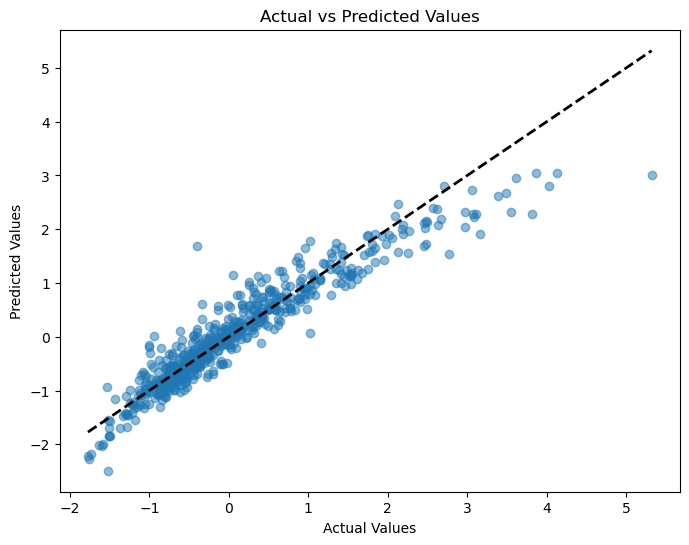

In [112]:
# Create a figure and axis object
fig, ax = plt.subplots(figsize=(8, 6))

# Scatter plot of actual vs predicted values
ax.scatter(y_val, y_pred, alpha=0.5)

# Add a diagonal line for reference
ax.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'k--', lw=2)

# Set labels and title
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
ax.set_title('Actual vs Predicted Values')

# Show the plot
plt.show();

Let's try a **Ridge regression** now. Note that `sklearn` uses an $\alpha$ term, rather than $\lambda$, like in the text. The two are related. See the footnotes in Chapter 3. 

This code is running different Ridge regressions with different $\alpha$ terms, reporting the mean squared error for each. The error will go up as $\alpha$ increases, but we're looking for values where that increase isn't as large.

In [21]:
# The alpha used by Python's ridge should be the lambda in Hull's book times the number of observations
alphas=[0.01*1800, 0.02*1800, 0.03*1800, 0.04*1800, 0.05*1800, 0.075*1800,0.1*1800,0.2*1800, 0.4*1800]
mses=[]
for alpha in alphas:
    ridge=Ridge(alpha=alpha)
    ridge.fit(X_train,y_train)
    pred=ridge.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val,pred))

0.11703284346091351
0.11710797319752991
0.11723952924901117
0.11741457158889518
0.1176238406871146
0.11825709631198014
0.11900057469147925
0.12254649996292954
0.13073599680747128


Let's plot $\alpha$ values on the y-axis and MSE on the x-axis. 

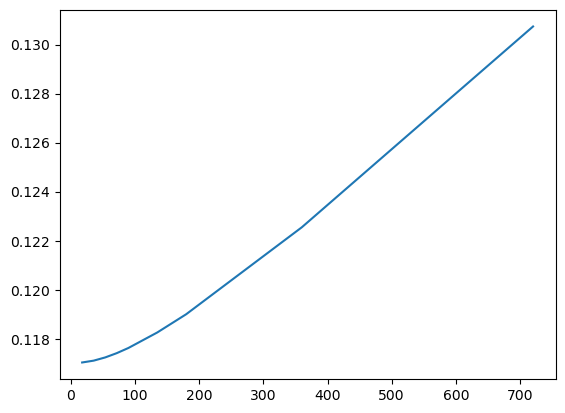

In [22]:
plt.plot(alphas, mses)

Note that this isn't exactly what's in the text. Figure 3.8 has $\lambda$ on the x-axis and Variance Unexplained on the y-axis. This plot gives the same information, though. 

Finally, we can turn to a **lasso regression**. We create the lasso object with a specific alpha hyperparameter. Then, we feed that object the necessary data.

In [24]:
# Here we produce results for alpha=0.05 which corresponds to lambda=0.1 in Hull's book
lasso = Lasso(alpha=0.05)
lasso.fit(X_train, y_train)

Lasso(alpha=0.05)

In [25]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(lasso.intercept_) + list(lasso.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotArea,0.044304
OverallQual,0.298079
OverallCond,0.0
YearBuilt,0.052091
YearRemodAdd,0.064471
BsmtFinSF1,0.115875
BsmtUnfSF,-0.0
TotalBsmtSF,0.10312


Do you see all of the zero values? The lasso model penalizes features that are either unimportant or similar to other variables in the model. Notice how all of the negative weights are gone.

Let's do the same thing we did above and vary our hyperparameter.

In [26]:
# We now consider different lambda values. The alphas are half the lambdas
alphas=[0.01/2, 0.02/2, 0.03/2, 0.04/2, 0.05/2, 0.075/2, 0.1/2]
mses=[]
for alpha in alphas:
    lasso=Lasso(alpha=alpha)
    lasso.fit(X_train,y_train)
    pred=lasso.predict(X_val)
    mses.append(mse(y_val,pred))
    print(mse(y_val, pred))

0.11654751909608796
0.116826879453111
0.11803348353132033
0.12012836764958999
0.12301536903084047
0.13178576395045638
0.1401719458448378


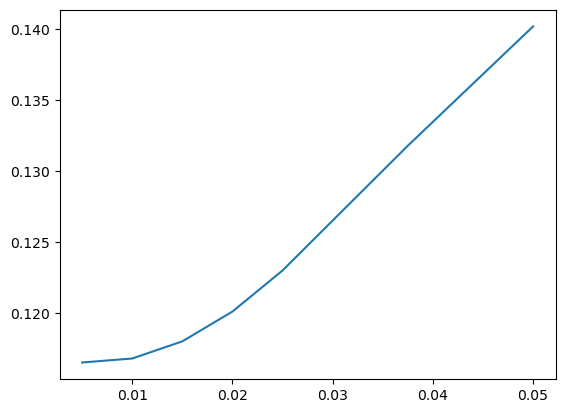

In [27]:
plt.plot(alphas, mses)

The text comments that the elastic net model doesn't really give much of an improvement over lasso. Let's estimate it here, though.

In [38]:
elastic = ElasticNet(alpha=0.05, l1_ratio=0.8, fit_intercept=True)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.05, l1_ratio=0.8)

What do the `alpha` and `l1_ratio` parameters do? From Claude GPT:

> In the scikit-learn implementation of Elastic Net regression (ElasticNet class), the alpha and l1_ratio parameters control the strength and balance between the L1 (Lasso) and L2 (Ridge) regularization penalties, respectively.
alpha (float): This parameter controls the overall strength of the regularization. A higher value of alpha increases the regularization effect, shrinking the coefficients more towards zero. When alpha=0, there is no regularization, and the model becomes a ordinary least squares linear regression.

> l1_ratio (float between 0 and 1): This parameter determines the balance between the L1 and L2 penalties in the Elastic Net regularization. Specifically: l1_ratio=1 means the penalty is an L1 penalty (Lasso). l1_ratio=0 means the penalty is an L2 penalty (Ridge). 0 < l1_ratio < 1 means the penalty is a combination of L1 and L2 penalties (Elastic Net).

> So, alpha controls the overall regularization strength, while l1_ratio determines how much of that regularization comes from the L1 penalty vs the L2 penalty. In practice, you would tune both alpha and l1_ratio using cross-validation to find the best combination for your specific data. Common values for l1_ratio are 0.5 (balanced Elastic Net), 0.2, or 0.8 depending on whether you want more L2 or L1 regularization respectively.

In [39]:
# DataFrame with corresponding feature and its respective coefficients
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(elastic.intercept_) + list(elastic.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotArea,0.051311
OverallQual,0.283431
OverallCond,0.005266
YearBuilt,0.059446
YearRemodAdd,0.067086
BsmtFinSF1,0.11673
BsmtUnfSF,-0.0
TotalBsmtSF,0.096558


Watch what happens when I set `l1_ratio` = 1. I get the lasso model!

In [41]:
elastic = ElasticNet(alpha=0.05, l1_ratio=1, fit_intercept=True)
elastic.fit(X_train, y_train)

ElasticNet(alpha=0.05, l1_ratio=1)

In [42]:
coeffs = pd.DataFrame(
    [
        ['intercept'] + list(X_train.columns),
        list(elastic.intercept_) + list(elastic.coef_)
    ]
).transpose().set_index(0)
coeffs

,1
0,
intercept,-0.0
LotArea,0.044304
OverallQual,0.298079
OverallCond,0.0
YearBuilt,0.052091
YearRemodAdd,0.064471
BsmtFinSF1,0.115875
BsmtUnfSF,-0.0
TotalBsmtSF,0.10312


Finally, I'm going to [follow along with this example](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html) and try something a little fancier. Let's use model fit statistics to choose our hyperparameters for us, rather than "guessing" like we did above. 

A few things to note:

- I'm using `make_pipeline`. This is a very common and useful function that let's you take your take, scale it, define criteria for model selection, etc. You basically transform your data in a series of steps and then ask for the model. Our data was already scaled, so I didn't do anything in the pipeline. 
- I'm asking for the [aic criterion](https://en.wikipedia.org/wiki/Akaike_information_criterion). This is a measure of best fit. I will also ask for the [bic criterion](https://en.wikipedia.org/wiki/Bayesian_information_criterion), another measure of best fit. The smaller the value, the better the model fits the data.
- `LassoLarsIC` tells the code to run the lasso model, which we then fit on our training data. This function is going to pick a bunch of alpha values for us, fit the model, and report the requested criterion back to us.


Here's a description of `make_pipeline` from Claude GPT:

> `make_pipeline` is a utility function provided by scikit-learn that creates a Pipeline object, which is a sequence of transformers and an estimator. It is a convenient way to chain multiple estimators into a single unit.
The make_pipeline function takes any number of estimators as arguments and returns a Pipeline object. The estimators are applied in the order they are passed to the function. The last estimator is always a classifier or regressor, while the other estimators are transformers (preprocessors).

> Some key features and benefits of using make_pipeline are:

>Convenience: It provides a simple and readable way to define a sequence of estimators, making the code more concise and easier to maintain.

>Automated Data Flow: The Pipeline object automatically applies the transformers to the input data and passes the transformed data to the final estimator. This avoids the need to manually handle the data flow between estimators.

>Consistency: All estimators in the pipeline, except the last one, must be transformers (i.e., have a transform method). This consistency makes it easier to understand and reason about the data flow.

>Persistence: The entire pipeline can be persisted to disk using the joblib module, making it easy to reuse the same preprocessing and modeling steps in different environments.

>Parallelization: Some transformers in the pipeline can be parallelized using the n_jobs parameter, potentially leading to faster processing times.

>Cross-Validation: The entire pipeline can be used in cross-validation loops, ensuring that the same preprocessing steps are applied to both the training and validation data.

> Overall, make_pipeline simplifies the process of chaining multiple estimators together and helps to create more readable, maintainable, and efficient code for machine learning workflows.


In [7]:
lasso_lars_ic = make_pipeline(LassoLarsIC(criterion="aic")).fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [8]:
results = pd.DataFrame(
    {
        "alphas": lasso_lars_ic[-1].alphas_,
        "AIC criterion": lasso_lars_ic[-1].criterion_,
    }
).set_index("alphas")
alpha_aic = lasso_lars_ic[-1].alpha_

In [10]:
lasso_lars_ic.set_params(lassolarsic__criterion="bic").fit(X_train, y_train)
results["BIC criterion"] = lasso_lars_ic[-1].criterion_
alpha_bic = lasso_lars_ic[-1].alpha_

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


You can see below that small values of alpha give us the best model fit, no matter the criteria used. This confirms what we saw graphically above. 

In [11]:
def highlight_min(x):
    x_min = x.min()
    return ["font-weight: bold" if v == x_min else "" for v in x]

results.style.apply(highlight_min)

,AIC criterion,BIC criterion
alphas,,
0.826071,23582.434975,23582.434975
0.593921,15937.406796,15943.382017
0.470226,11958.039541,11969.989983
0.416272,10256.631120,10274.556783
0.360729,8627.920156,8651.821040
0.242065,5909.744762,5939.620866
0.234301,5740.130523,5775.981848
0.196832,4957.887848,4999.714394
0.175594,4555.821202,4603.622969


Let's make a plot. We'll use `matplotlib` and the *ax* method.

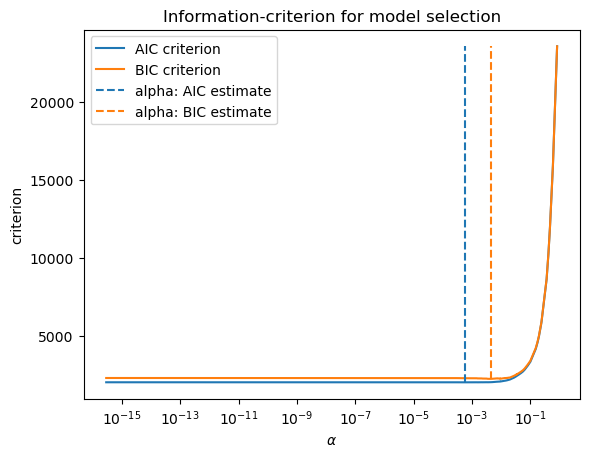

In [12]:
ax = results.plot()
ax.vlines(
    alpha_aic,
    results["AIC criterion"].min(),
    results["AIC criterion"].max(),
    label="alpha: AIC estimate",
    linestyles="--",
    color="tab:blue",
)
ax.vlines(
    alpha_bic,
    results["BIC criterion"].min(),
    results["BIC criterion"].max(),
    label="alpha: BIC estimate",
    linestyle="--",
    color="tab:orange",
)
ax.set_xlabel(r"$\alpha$")
ax.set_ylabel("criterion")
ax.set_xscale("log")
ax.legend()
_ = ax.set_title(
    f"Information-criterion for model selection"
)

Finally, let's try an idea called [cross validation](https://scikit-learn.org/stable/auto_examples/linear_model/plot_lasso_model_selection.html). We've already see this a bit when we split our data into **training** and **validation** samples. From Claude GPT:

> Cross-validation is a technique used in machine learning to evaluate the performance of a model and tune its hyperparameters. It helps to estimate how well the model will generalize to unseen data, and it is particularly useful when the available data is limited. The main idea behind cross-validation is to split the dataset into two parts: a training set and a validation set. The model is trained on the training set and evaluated on the validation set. This process is repeated multiple times, with different portions of the data being used for training and validation in each iteration.

> There are several types of cross-validation techniques, but the most common is **k-fold cross-validation**. Here's how it works:

> 1. The dataset is randomly partitioned into k equal-sized subsets or "folds".

> 2. One of the k folds is held out as the validation set, and the remaining k-1 folds are used for training the model. The model is trained on the k-1 folds and evaluated on the held-out validation fold.

> 3. This process is repeated k times, with each of the k folds being used as the validation set exactly once.

> 4. The performance metric (e.g., accuracy, F1-score, mean squared error) is calculated for each iteration, and the final performance is the average of the k iterations.

> Cross-validation has several advantages:

> It provides a more reliable and unbiased estimate of the model's performance compared to a single train-test split.

> It helps to prevent overfitting by evaluating the model on data that it has not seen during training.

> It allows for effective hyperparameter tuning by selecting the hyperparameters that yield the best average performance across the cross-validation folds.

> It makes efficient use of the available data by using every data point for both training and validation at some point.

> Cross-validation is widely used in machine learning competitions, research, and real-world applications. It is a crucial technique for evaluating and tuning models, especially when dealing with limited data or when it is important to estimate the model's generalization performance accurately.



We are going to use some **built-in cross-validation tools**. This means that we don't have to manually split our data set. So, I'm going to use all of the observations and have `sklearn` perform the cross-fold validation for me. I'll need to redefine my Dataframes.

In [13]:
X_all= data.drop('Sale Price', axis=1)
y_all = data[['Sale Price']]

In [14]:
modelcv = make_pipeline(LassoCV(cv=20)).fit(X_all, y_all)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:1623: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Again, *modelcv* is a pipeline. A pipeline is an object. This object contains our lasso model fit. We'll pull this out below and define it as *lasso*. 

In [15]:
modelcv

Pipeline(steps=[('lassocv', LassoCV(cv=20))])

In [16]:
lasso = modelcv[-1]
lasso

LassoCV(cv=20)

OK, what did we do here? Let's have Claude GPT tell us:

> In scikit-learn, LassoCV(cv=20) refers to the Lasso regression model with cross-validation for tuning the regularization parameter (alpha). Here's what the components mean:

> LassoCV: This is the class name for the Lasso regression model with built-in cross-validation for automatically tuning the regularization strength parameter (alpha).

> cv=20: This is a parameter that specifies the number of folds for cross-validation. In this case, it means that the cross-validation process will be repeated 20 times, each time using a different 1/20th of the data as the validation set and the remaining 19/20ths as the training set.

> The LassoCV class performs the following steps:

> 1. It splits the data into cv (20 in this case) folds or subsets.

> 2. For each fold:

> 2a. It holds out that fold as the validation set.

> 2b. It trains the Lasso regression model on the remaining cv-1 folds, using a range of different alpha values.

> 2c. It evaluates the performance of the model on the held-out validation fold for each alpha value.

> After all folds have been processed, it selects the alpha value that gives the best average performance across all folds.

> Finally, it retrains the Lasso regression model on the entire dataset using the optimal alpha value found through cross-validation.

> By using cross-validation, LassoCV can automatically find the optimal value of the regularization parameter (alpha) that balances the trade-off between model complexity and goodness of fit. This helps to prevent overfitting and improve the model's generalization performance. The choice of cv=20 is a common practice, as it provides a good balance between computational cost and reliable estimation of the model's performance. However, the optimal value of cv can depend on the size of the dataset and the complexity of the problem.

I'm going to print my mse values in order to find some reasonable min and max values for the graph below. Remember, Hull has scaled the y variables to have a mean of zero. So, the MSEs are going to be tiny - we're trying to fit small numbers, not something like an actual house price in dollars.

In [17]:
lasso.mse_path_

array([[0.77633271, 1.07063185, 1.05436677, ..., 0.84969106, 1.56035964,
        0.79584759],
       [0.70154334, 0.9891733 , 0.96733781, ..., 0.77346046, 1.47527881,
        0.7193977 ],
       [0.63714142, 0.91751831, 0.8902093 , ..., 0.70772083, 1.36291727,
        0.6540212 ],
       ...,
       [0.10246679, 0.12323289, 0.13160113, ..., 0.15353655, 0.13306539,
        0.08403212],
       [0.10246497, 0.12334693, 0.13184121, ..., 0.15359582, 0.13299175,
        0.08398819],
       [0.10246159, 0.12345542, 0.13206417, ..., 0.15365155, 0.13292367,
        0.08394793]])

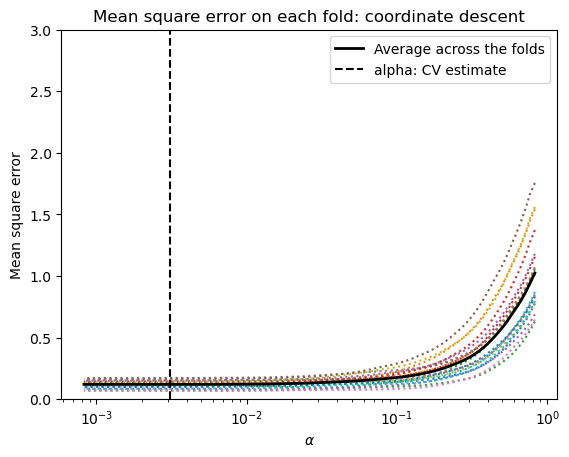

In [18]:
ymin, ymax = 0, 3

plt.semilogx(lasso.alphas_, lasso.mse_path_, linestyle=":")
plt.plot(
    lasso.alphas_,
    lasso.mse_path_.mean(axis=-1),
    color="black",
    label="Average across the folds",
    linewidth=2,
)
plt.axvline(lasso.alpha_, linestyle="--", color="black", label="alpha: CV estimate")

plt.ylim(ymin, ymax)
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean square error")
plt.legend()
_ = plt.title(
    f"Mean square error on each fold: coordinate descent"
)

### Hyperparamters and model overfit

Again, what's the point of all of this? We're trying to find our model **hyperparameters** that we can then take to data outside of our training set. We are trying to avoid **overfitting**. This is a problem in machine learning and, especially, in financial applications. It is easy to look at past financial and fit a model that will predict returns **in sample**, in the data we are using. But, will this work on new data? If you overfit your model, you risk making precisely incorrect predictions.

Here's a [nice explanation](https://scikit-learn.org/stable/modules/cross_validation.html) on what is going on. This is all part of a much larger discussion on [model selection](https://scikit-learn.org/stable/model_selection.html)

### Interpreting linear regression models

Chapter 10.1 discusses how to interpret our results. Traditionally, machine learning hasn't been as interested in interpreting the model - we just want predicted values! However, as machine learning, statistics, econometrics, and specific domain knowledge (i.e. finance) mix, we are becoming more interested in exactly how to interpret our results.

As the test notes, you can't tell a loan applicant that they got rejected because "the algo said so"! You need to know why. This also gets into biases in our data. Is your model doing something illegal and/or unethical?

From the Hull text:

> The weight, $b_j$, can be interpreted as the sensitivity of the prediction to the value of the feature $j$. If the value of feature $j$ increases by an amount $u$ with all other features remaining the same, the value of the target increases by $b_{j,u}$. In the case of categorical features that are 1 or 0, the  weight gives the impact on a prediction of the target of changing the  category of the feature when all other features are kept the same. 

> The bias, $a$, is a little more difficult to interpret. It is the value of the  target if all the feature values are zero. However, feature values of zero make no sense in many situations.

The text suggests setting all of the X features at the average value and then adding the intercept, $a$. This $a^*$ value is the predicted y if all features are at their mean. 

Note that to do this, you should use the model results with the unscaled data. From the text:

> To improve interpretability, the Z-score scaling used for Table 3.7 has been reversed in Table 10.1. (It will be recalled that scaling was necessary for Lasso.) This means that the feature weights in Table 3.7 are divided by the standard deviation of  the feature and multiplied by the standard deviation of the house price to get the feature weights in Table 10.1.

As mentioned above, going back and forth between scaled and unscaled features is easier if you just let `sklearn` do it for you.

This is also a [nice summary](https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#sphx-glr-auto-examples-inspection-plot-linear-model-coefficient-interpretation-py) of how to interpret regression results.




### Some worked examples

We are just scratching the surface on machine learning in this course. Here are some complete examples that all use housing price data. Some things to pay attention to:

- How are the data organized? How is it split into training and test data?
- How is the data quality checked? How are missing values handled? How about outliers?
- What feature engineering steps are used? Are logs taken? Are there categorical variables in the regressions? Are the variables scaled?
- What visualizations are used to look at the data before modeling? Why are they used?
- What models are used? How are they compared?

[Example One.](https://www.kaggle.com/code/erick5/predicting-house-prices-with-machine-learning/notebook)
[Example Two.](https://www.dataquest.io/blog/kaggle-getting-started/)
